In [7]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import pickle

In [8]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [9]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

In [10]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [33]:
colors = mpl.cm.get_cmap("tab20").colors

### Load coverage

In [12]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [13]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [14]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [15]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [16]:
clust["snps_to_clusters"].shape

(500, 11768)

In [17]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single allelic DP iteration

In [18]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [19]:
min_tots = np.zeros(clust_uj.max() + 1)
maj_tots = np.zeros(clust_uj.max() + 1)
clusts= clust_uj[499]
phases = clust["snps_to_phases"][499]
SNPs2 = SNPs.copy()
SNPs2.iloc[phases, [0, 1]] = SNPs2.iloc[phases, [1, 0]]

maj_tots += npg.aggregate(clusts, SNPs2["maj"], size = clust_uj.max() + 1)
min_tots += npg.aggregate(clusts, SNPs2["min"], size = clust_uj.max() + 1)

min_tots /= clust_uj.shape[0]
maj_tots /= clust_uj.shape[0]

min_tots = min_tots[np.flatnonzero(prune_idx)]
maj_tots = maj_tots[np.flatnonzero(prune_idx)]

In [20]:
f_prune = (min_tots/(min_tots + maj_tots))

In [22]:
with open('./exome_results/Cov_DP_model.pickle', 'rb') as f:
    dp_pickle = pickle.load(f)

In [23]:
def create_seg_df(dp_pickle, SNPs2):
    global_seg_counter = 0
    draw_dfs = []

    for draw_num, dp_run in enumerate(dp_pickle.DP_runs):
        print('concatenating dp run ', draw_num)
        a_cov_seg_df = dp_run.cov_df.copy()

        # add minor and major allele counts for each bin to the cov_seg_df here to allow for beta draws on the fly for each segment
        a_cov_seg_df['min_count'] = 0
        a_cov_seg_df['maj_count'] = 0
        min_col_idx = a_cov_seg_df.columns.get_loc('min_count')
        maj_col_idx = a_cov_seg_df.columns.get_loc('maj_count')

        SNPs2["cov_tidx"] = mut.map_mutations_to_targets(SNPs2, a_cov_seg_df, inplace=False)

        for idx, group in SNPs2.groupby('cov_tidx').indices.items():
            minor, major = SNPs2.iloc[group, [0, 1]].sum()
            a_cov_seg_df.iloc[int(idx), [min_col_idx, maj_col_idx]] = minor, major

        # add dp cluster annotations
        a_cov_seg_df['cov_DP_cluster'] = -1
        
        segs_to_clusts = dp_run.bins_to_clusters[-1]
        for s in range(len(segs_to_clusts)):
            a_cov_seg_df.loc[a_cov_seg_df['segment_ID'] == s, 'cov_DP_cluster'] = segs_to_clusts[s]

        # adding cluster mus and sigmas to df
        a_cov_seg_df['cov_DP_mu'] = 0
        a_cov_seg_df['cov_DP_sigma'] = 0

        for c in a_cov_seg_df.cov_DP_cluster.unique():
            dp_clust = a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c]
            r = dp_clust.covcorr.values
            C = np.c_[np.log(dp_clust['C_len'].values), dp_clust['C_RT_z'].values, dp_clust['C_GC_z'].values]
            endog = np.exp(np.log(r) - (C @ dp_pickle.beta).flatten())
            exog = np.ones(r.shape)
            sNB = statsNB(endog, exog)
            res = sNB.fit(disp=0)
            mu = res.params[0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_mu'] = mu
            H = sNB.hessian(res.params)
            mu_sigma = np.linalg.inv(-H)[0, 0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_sigma'] = mu_sigma
        
        #add next_g for ease of plotting down the line
        a_cov_seg_df["next_g"] = np.r_[a_cov_seg_df.iloc[1:]["start_g"], 2880794554]
        
        # double segments to account for second allele
        num_bins = len(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df = a_cov_seg_df.append(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df['allele'] = 0
        allele_col_idx = a_cov_seg_df.columns.get_loc('allele')

        # minor
        a_cov_seg_df.iloc[:num_bins, allele_col_idx] = -1
        # major
        a_cov_seg_df.iloc[num_bins:, allele_col_idx] = 1

        a_clusts = a_cov_seg_df['allelic_cluster'].values
        cov_clusts = a_cov_seg_df['cov_DP_cluster'].values
        a_cur = a_clusts[0]
        cov_cur = cov_clusts[0]
        a_cov_seg_df['a_cov_segID'] = -1
        a_cov_idx = a_cov_seg_df.columns.get_loc('a_cov_segID')
        for i, (a_clust, cov_clust) in enumerate(zip(a_clusts, cov_clusts)):
            if a_cur == a_clust and cov_cur == cov_clust:
                pass
            else:
                global_seg_counter += 1
                a_cur = a_clust
                cov_cur = cov_clust
            a_cov_seg_df.iloc[i, a_cov_idx] = global_seg_counter

        # adding counts by segment
        a_cov_seg_df['seg_min_count'] = 0
        a_cov_seg_df['seg_maj_count'] = 0
        min_col = a_cov_seg_df.columns.get_loc('seg_min_count')
        maj_col = a_cov_seg_df.columns.get_loc('seg_maj_count')
        for idx, group in a_cov_seg_df.groupby('a_cov_segID').indices.items():
            a_cov_seg_df.iloc[group, [min_col, maj_col]] = a_cov_seg_df.iloc[group, [min_col_idx, maj_col_idx]].sum()
        
        a_cov_seg_df['dp_draw'] = draw_num
        draw_dfs.append(a_cov_seg_df)
    return pd.concat(draw_dfs)

In [24]:
multidraw_df = create_seg_df(dp_pickle, SNPs2)

concatenating dp run  0
concatenating dp run  1
concatenating dp run  2
concatenating dp run  3
concatenating dp run  4
concatenating dp run  5
concatenating dp run  6
concatenating dp run  7
concatenating dp run  8
concatenating dp run  9


In [216]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [221]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta)

In [222]:
a_cov_dp.run(1)

n unassigned: 1547
n unassigned: 1429
n unassigned: 1324
n unassigned: 1234
n unassigned: 1128
n unassigned: 1034
n unassigned: 957
n unassigned: 886
n unassigned: 814
n unassigned: 759
n unassigned: 698
n unassigned: 648
n unassigned: 600
n unassigned: 561
n unassigned: 527
n unassigned: 481
n unassigned: 442
n unassigned: 407
n unassigned: 367
n unassigned: 334
n unassigned: 307
n unassigned: 284
n unassigned: 258
n unassigned: 238
n unassigned: 215
n unassigned: 204
n unassigned: 190
n unassigned: 176
n unassigned: 169
n unassigned: 134
n unassigned: 70
n unassigned: 17
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([ 1,  5,  1, ..., 12, 12, 12])],
 SortedDict({1: 224, 2: 57, 3: 265, 5: 26, 7: 254, 8: 196, 9: 211, 11: 81, 12: 16, 13: 23, 15: 43, 16: 60, 17: 41, 18: 5, 19: 9, 20: 7, 21: 6, 22: 10, 23: 8, 24: 5, 25: 1}))

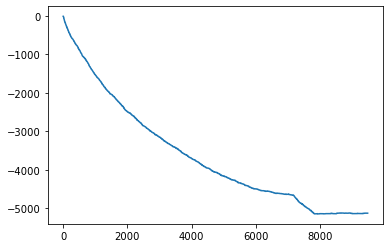

In [223]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)], a_cov_dp.ML_total_history)

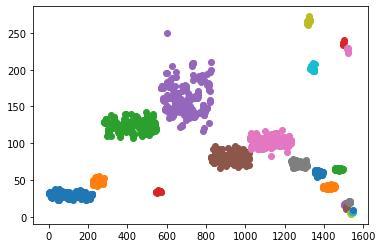

In [224]:
counter=0
for c in a_cov_dp.cluster_dict:
    vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

In [39]:
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

In [40]:
ADP_dict[0]

(465060.97873851476, 94053.93291680975)

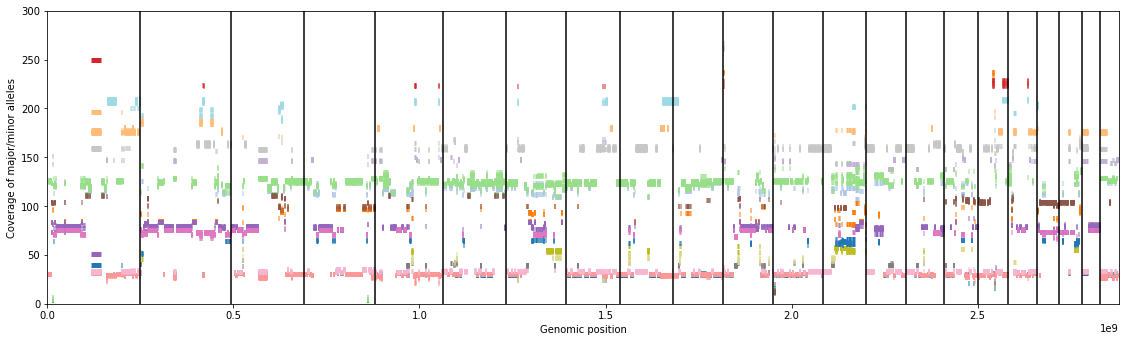

In [42]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        for (_, st, en, _,cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

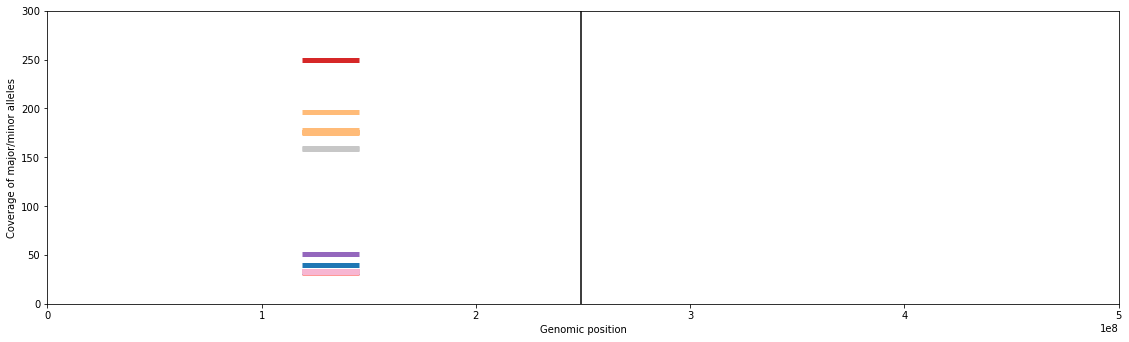

In [66]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        x = x.loc[(x.start_g > 0.118e9) & (x.start_g < 0.12e9)]
        for (_, st, en, _, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 0.5e9));
plt.ylim([0, 300]);

In [144]:
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
a_dict = {}
for name, x in full_df:
    maj_count, min_count = x.maj_count.sum(), x.min_count.sum()
    tuple_len = len(x)
    if name[2] == 1:
        f = x.maj_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    else:
        f =x.min_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    a_dict[name] = (maj_count, min_count, f, tuple_len)
def _tst_fun(x):
    name = (x.allelic_cluster.values[0], x.cov_DP_cluster.values[0], x.allele.values[0],x.dp_draw.values[0])

    maj_count, min_count, f, tup_len = a_dict[name]
    if tup_len < 10:
        maj_count, min_count = ADP_dict[name[0]]
        if name[2] == -1:
            f = min_count / (min_count+maj_count)
        else:
            f = maj_count / (min_count+maj_count)
    num_bins = len(x)
    return pd.Series({'DP_mu':np.exp(x.cov_DP_mu.values[0]), 'tup_maj_count':maj_count,  'tup_min_count':min_count, 'tup_len':tup_len, 'num_bins':num_bins, 'f':f,'mu*f':np.exp(x.cov_DP_mu.values[0]) * f})

    

In [128]:
multidraw_df.loc[(multidraw_df.start_g > 0.118e9) & (multidraw_df.start_g < 0.12e9)].groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      2        207.715236   62067.287622   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      8        207.362693   67875.371563   
                                1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      2        207.715236   62067.287622   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      8        207.362693   67875.371563   
                1              -1     3        193.109702  155981.886024   
                                      7        191.331170  146371.243752   
                                1     3        193.109702  155981.886024   
                                      7        191.331170  146371.243752   
                8              -1     4        235.891947  465060.978739   
                                1     4        235.891947  465060.978739   
                11             -1     9        300.591800  465060.978739   
                                1     9        300.591800  465060.978739   

                                               tup_min_count  tup_len  \
allelic_cluster cov_DP_cluster allele dp_draw                           
0               0              -1     0          6632.547786     85.0   
                                      1         14419.431626    185.0   
                                      2         11355.669806    162.0   
                                      5         11126.001538    157.0   
                                      6         14289.861512    184.0   
                                      8         12228.638783    166.0   
                                1     0          6632.547786     85.0   
                                      1         14419.431626    185.0   
                                      2         11355.669806    162.0   
                                      5         11126.001538    157.0   
                                      6         14289.861512    184.0   
                                      8         12228.638783    166.0   
                1              -1     3         32683.231368    505.0   
                                      7         30665.947424    508.0   
                                1     3         32683.231368    505.0   
                                      7         30665.947424    508.0   
                8              -1     4         94053.932917      4.0   
                                1     4         94053.932917      4.0   
                11             -1     9         94053.932917      3.0   
                                1     9         94053.932917      3.0   

                                                      f        mu*f  
allelic_cluster cov_DP_cluster allele dp_draw                        
0               0              -1     0        0.155603   32.269297  
                                      1        0.160358   33.509002  
                                      2        0.154661   32.125451  
                                      5        0.154575   32.554123  
                                      6        0.161566   33.935915  
                                      8        0.152660   31.655887  
                                1     0        0.844397  175.112512  
                                      1        0.839642  175.454973  
                                      2        0.845339  175.589785  
  

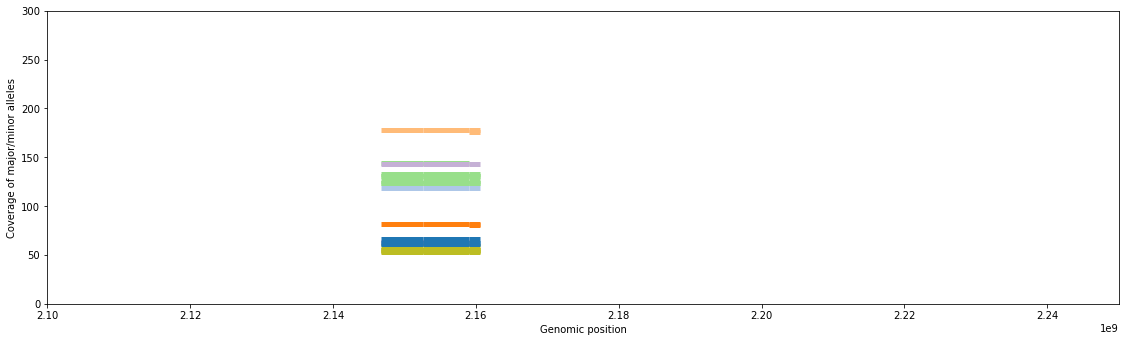

In [202]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        x = x.loc[(x.start_g > 2.14e9) & (x.start_g < 2.16e9)]
        for (_, st, en, _, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((2.1e9, 2.25e9));
plt.ylim([0, 300]);

In [145]:
multidraw_df.loc[(multidraw_df.start_g > 2.14e9) & (multidraw_df.start_g < 2.16e9)].groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
1               0              -1     1        208.963974    6625.979265   
                                      4        207.172979  280999.890136   
                                1     1        208.963974    6625.979265   
                                      4        207.172979  280999.890136   
                1              -1     2        192.432542    8448.792640   
                                      8        192.409375   11943.634763   
                                      9        192.578990   10067.622551   
                                1     2        192.432542    8448.792640   
                                      8        192.409375   11943.634763   
                                      9        192.578990   10067.622551   
                2              -1     4        256.604296    7526.452007   
                                      5        259.380869    8050.759492   
                                1     4        256.604296    7526.452007   
                                      5        259.380869    8050.759492   
                4              -1     6        171.818989   13079.936860   
                                      7        181.131511   10574.658783   
                                1     6        171.818989   13079.936860   
                                      7        181.131511   10574.658783   
                7              -1     0        178.256547   20165.464798   
                                      3        177.501159   20514.209728   
                                1     0        178.256547   20165.464798   
                                      3        177.501159   20514.209728   

                                               tup_min_count  tup_len  \
allelic_cluster cov_DP_cluster allele dp_draw                           
1               0              -1     1          3080.239392     24.0   
                                      4        123831.392027      9.0   
                                1     1          3080.239392     24.0   
                                      4        123831.392027      9.0   
                1              -1     2          3751.804904     31.0   
                                      8          5640.252009     45.0   
                                      9          4783.500201     39.0   
                                1     2          3751.804904     31.0   
                                      8          5640.252009     45.0   
                                      9          4783.500201     39.0   
                2              -1     4          3455.364222     25.0   
                                      5          3711.868090     30.0   
                                1     4          3455.364222     25.0   
                                      5          3711.868090     30.0   
                4              -1     6          5831.265309     53.0   
                                      7          4624.200580     44.0   
                                1     6          5831.265309     53.0   
                                      7          4624.200580     44.0   
                7              -1     0          8912.265055     95.0   
                                      3          8946.852109     95.0   
                                1     0          8912.265055     95.0   
                                      3          8946.852109     95.0   

                                               num_bins         f        mu*f  
allelic_cluster cov_DP_cluster allele dp_draw                                  
1               0              -1     1             3.0  0.317347   66.314091  
                                      4             2.0  0.305884   63.370889  
                                1     1             3.0  0.682653  142.649883  
                                      4             2.0  0.694116  143.802

In [199]:
tst_chunk = multidraw_df.loc[(multidraw_df.allelic_cluster == 1) & (multidraw_df.cov_DP_cluster==0) & (multidraw_df.dp_draw == 1) & (multidraw_df.allele == 1)]

In [200]:
# ADP 1 CDP 0
tst_chunk

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID,min_count,maj_count,cov_DP_cluster,cov_DP_mu,cov_DP_sigma,next_g,allele,a_cov_segID,seg_min_count,seg_maj_count,dp_draw
13356,13,32928997,32929425,115574,173983,2117695298,2117695726,429,0.734461,-1.030549,0.344988,-0.267572,1,20,83.943565,167.440000,0,5.342162,0.000051,2117782825,1,4958,216.912415,441.454488,1
13357,13,33016524,33018263,498217,741134,2117782825,2117784564,1740,0.806537,-0.322812,0.371839,-0.208921,1,20,71.760000,179.254488,0,5.342162,0.000051,2117998676,1,4958,216.912415,441.454488,1
13358,13,33232375,33232462,14782,22817,2117998676,2117998763,88,0.683295,-1.576470,0.329545,-0.303408,1,20,61.208850,94.760000,0,5.342162,0.000051,2118394204,1,4958,216.912415,441.454488,1
13360,13,33634815,33635917,389155,581378,2118401116,2118402218,1103,0.763452,-0.737865,0.498640,0.020688,1,20,122.417699,264.040000,0,5.342162,0.000051,2118466518,1,4960,608.516662,1211.187484,1
13361,13,33700217,33700377,53533,84807,2118466518,2118466678,161,0.796357,-0.418849,0.496894,0.017944,1,20,61.208850,138.920000,0,5.342162,0.000051,2118469366,1,4960,608.516662,1211.187484,1
13362,13,33703065,33704426,512989,768515,2118469366,2118470727,1362,0.796357,-0.418849,0.558737,0.109735,1,20,424.890114,808.227484,0,5.342162,0.000051,2121151272,1,4960,608.516662,1211.187484,1
13388,13,47469629,47470041,120495,183929,2132235930,2132236342,413,0.685249,-1.554881,0.435835,-0.084655,1,20,95.680000,194.119494,0,5.342162,0.000051,2134560774,1,4968,95.680000,194.119494,1
13410,13,61985375,61988099,1030531,1533414,2146751676,2146754400,2725,0.694102,-1.457832,0.476330,-0.015130,1,20,100.557396,214.360000,0,5.342162,0.000051,2152565837,1,4972,257.077168,563.040000,1
13411,13,67799536,67802572,989083,1478285,2152565837,2152568873,3037,0.736112,-1.013573,0.444847,-0.068640,1,20,100.557396,219.880000,0,5.342162,0.000051,2159105375,1,4972,257.077168,563.040000,1
13412,13,74339074,74339137,12692,21391,2159105375,2159105438,64,0.776694,-0.607858,0.484375,-0.002024,1,20,55.962377,128.800000,0,5.342162,0.000051,2160632538,1,4972,257.077168,563.040000,1


In [201]:
#looking at corrected coverage for this tuple
np.exp(np.log(tst_chunk['covcorr'].values) - (np.c_[np.log(tst_chunk['C_len']), tst_chunk['C_RT_z'], tst_chunk['C_GC_z']] @ a_cov_dp.beta).flatten())

array([243.57327484, 209.69266451, 183.80865114, 189.31857711,
       210.65825594, 173.06667953, 200.43523033, 199.03584985,
       184.03533641, 140.15608957, 229.02606607, 104.08033373,
       156.88541378, 279.20423251, 192.98181469, 208.42003265,
       303.826151  , 264.07424486, 315.436934  , 327.61070269,
       261.19742205, 234.16564086, 265.13526563, 288.93845789])

In [168]:
def visualize_DP_clust(self, run_idx, cluster_num, seg_num):
    if run_idx > len(self.DP_runs):
        raise ValueError('DP run index out of range')

    cov_dp = self.DP_runs[run_idx]
    cur = 0
    f, axs = plt.subplots(1, figsize = (25,10))
    for c in [cluster_num]:
        clust_start = cur
        for seg in cov_dp.cluster_dict[c]:
            len_seg = len(cov_dp.segment_r_list[seg])
            if seg == seg_num:
                axs.scatter(np.r_[cur:len_seg+cur], np.exp(np.log(cov_dp.segment_r_list[seg]) - (cov_dp.segment_C_list[seg] @ cov_dp.beta).flatten()), color='k')
            else:
                axs.scatter(np.r_[cur:len_seg+cur], np.exp(np.log(cov_dp.segment_r_list[seg]) - (cov_dp.segment_C_list[seg] @ cov_dp.beta).flatten()))

            cur += len_seg

        axs.add_patch(mpl.patches.Rectangle((clust_start,0), cur-clust_start, 500, fill=True, alpha=0.15, color = colors[c % 10]))

In [166]:
dp_pickle.DP_runs[1].cov_df.loc[(dp_pickle.DP_runs[1].cov_df.start_g > 2.14e9) & (dp_pickle.DP_runs[1].cov_df.start_g < 2.16e9)]

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID
134069,13,61985375,61988099,1030531,1533414,2146751676,2146754400,2725,0.694102,-1.457832,0.476330,-0.015130,1,20
134074,13,67799536,67802572,989083,1478285,2152565837,2152568873,3037,0.736112,-1.013573,0.444847,-0.068640,1,20
134168,13,74339074,74339137,12692,21391,2159105375,2159105438,64,0.776694,-0.607858,0.484375,-0.002024,1,20


In [ ]:
dp_pickle.DP_runs[1].cluster_dict

SortedDict({0: SortedSet([0, 4, 20, 33, 35, 44, 48, 94, 97, 102, 126]), 1: SortedSet([3, 12, 24, 27, 42, 46, 90, 91, 101, 118, 127]), 2: SortedSet([50, 60, 64, 66, 71, 78, 81, 100, 104, 105, 107]), 3: SortedSet([5, 32, 36, 38, 41, 49, 57, 59, 61, 63, 70, 72, 73, 82, 84, 86, 99, 122]), 4: SortedSet([14, 16, 18, 21, 29, 30, 34, 40, 47, 52, 67, 68, 80, 115]), 5: SortedSet([7, 9, 13, 17, 19, 23, 25, 28, 96, 106, 109, 111, 113]), 6: SortedSet([39, 56, 98, 108, 110, 117]), 7: SortedSet([2, 15, 43, 51, 53, 55, 65, 79, 88, 93, 95, 103, 112, 114, 119, 120, 121, 123, 125, 129]), 8: SortedSet([6, 8, 10, 22, 58, 62, 69, 74, 75, 76, 83, 85, 87, 124, 130, 132]), 11: SortedSet([11, 26, 45, 54, 77, 89, 92, 128, 131]), 12: SortedSet([37, 116]), 15: SortedSet([1, 31])})

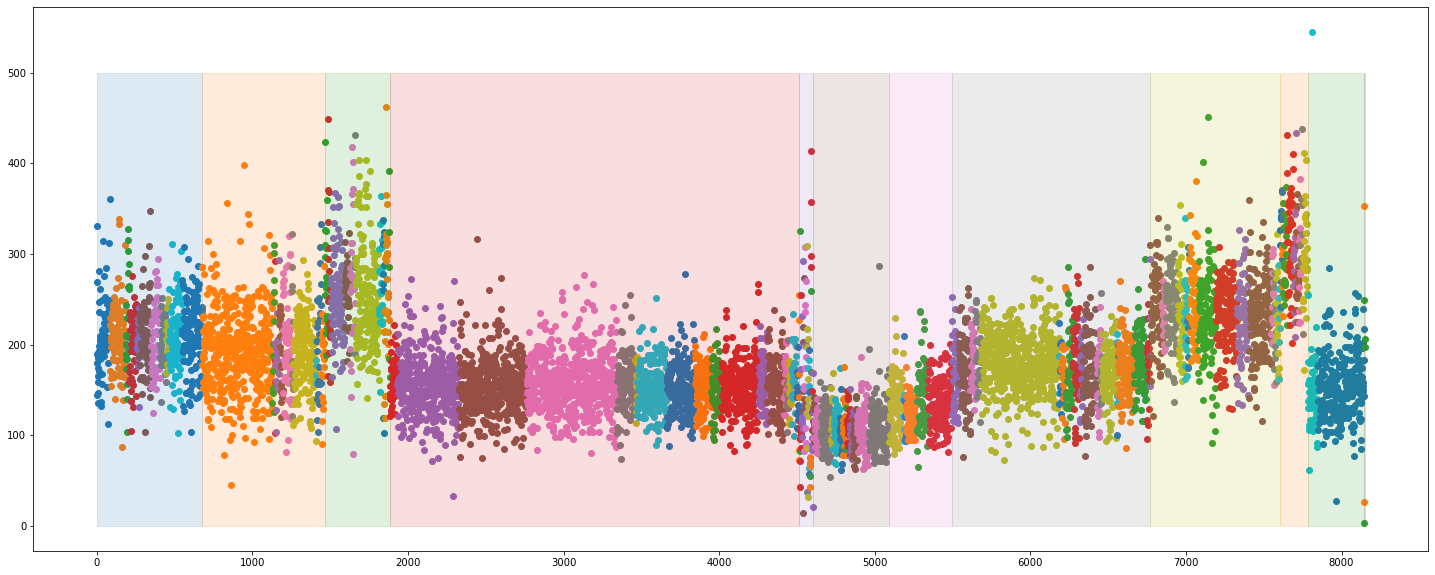

In [146]:
dp_pickle.visualize_DP_run(1, './tst')

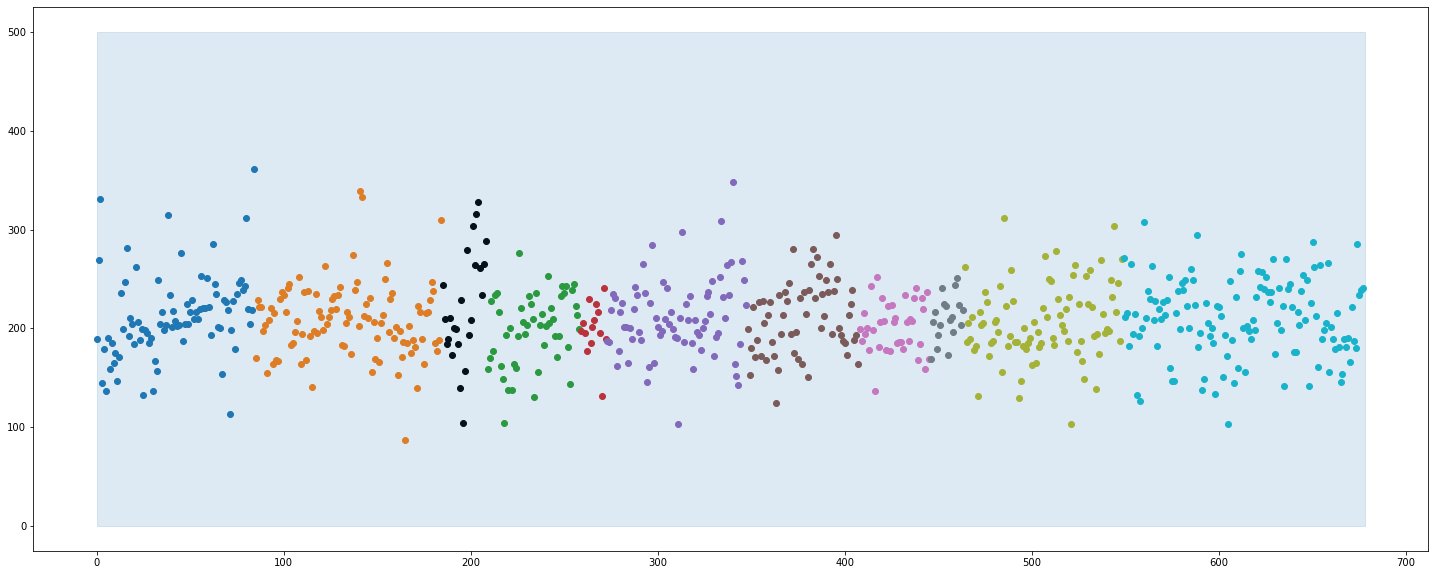

In [177]:
visualize_DP_clust(dp_pickle, 1, 0, 20)

In [174]:
dp_pickle.DP_runs[2].cov_df.loc[(dp_pickle.DP_runs[2].cov_df.start_g > 2.14e9) & (dp_pickle.DP_runs[2].cov_df.start_g < 2.16e9)]

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID
134069,13,61985375,61988099,1030531,1533414,2146751676,2146754400,2725,0.694102,-1.457832,0.476330,-0.015130,1,22
134074,13,67799536,67802572,989083,1478285,2152565837,2152568873,3037,0.736112,-1.013573,0.444847,-0.068640,1,22
134168,13,74339074,74339137,12692,21391,2159105375,2159105438,64,0.776694,-0.607858,0.484375,-0.002024,1,22


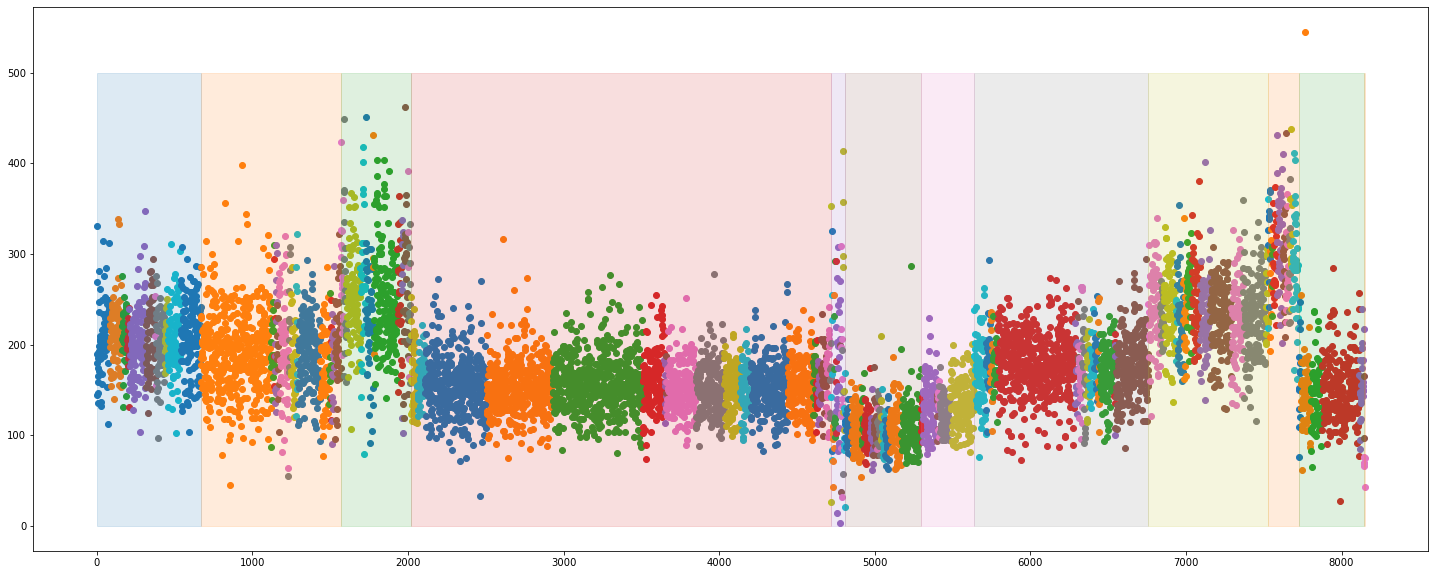

In [155]:
dp_pickle.visualize_DP_run(2, './tst')

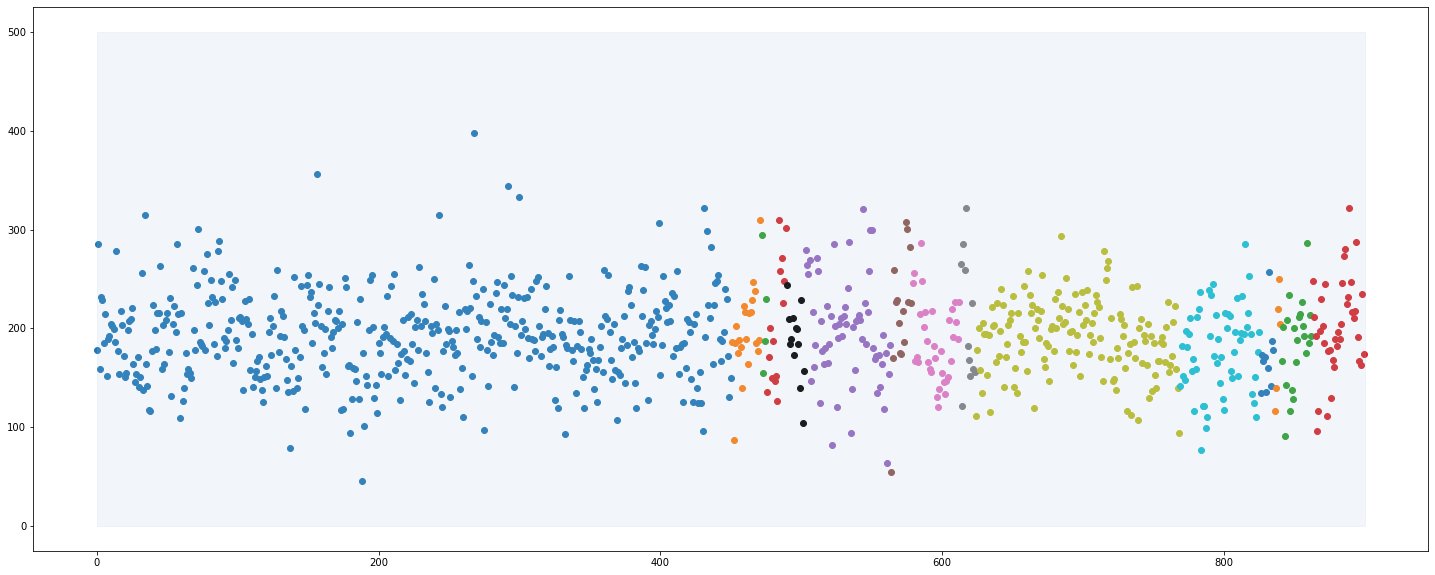

In [172]:
visualize_DP_clust(dp_pickle, 2, 1, 22)

In [206]:
dp_pickle.DP_runs[4].cov_df.loc[(dp_pickle.DP_runs[4].cov_df.start_g > 2.14e9) & (dp_pickle.DP_runs[4].cov_df.start_g < 2.17e9)]

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID
134069,13,61985375,61988099,1030531,1533414,2146751676,2146754400,2725,0.694102,-1.457832,0.476330,-0.015130,1,20
134074,13,67799536,67802572,989083,1478285,2152565837,2152568873,3037,0.736112,-1.013573,0.444847,-0.068640,1,20
134168,13,74339074,74339137,12692,21391,2159105375,2159105438,64,0.776694,-0.607858,0.484375,-0.002024,1,21
134175,13,75866237,75866407,42765,69052,2160632538,2160632708,171,0.778375,-0.591513,0.350877,-0.254327,4,51
134193,13,76055405,76055903,295124,450703,2160821706,2160822204,499,0.732696,-1.048731,0.693387,0.278688,1,21
134195,13,76101948,76101987,6929,11641,2160868249,2160868288,40,0.691218,-1.489314,0.575000,0.132186,1,21
134222,13,76381615,76382335,185321,277869,2161147916,2161148636,721,0.839030,-0.024211,0.460472,-0.041626,1,21
134231,13,76409368,76409475,32417,51384,2161175669,2161175776,108,0.839030,-0.024211,0.370370,-0.212018,1,21
134311,13,77738588,77738676,23572,38294,2162504889,2162504977,89,0.825329,-0.148684,0.460674,-0.041282,1,21
134319,13,77751882,77752089,56957,91857,2162518183,2162518390,208,0.825329,-0.148684,0.418269,-0.116847,1,21


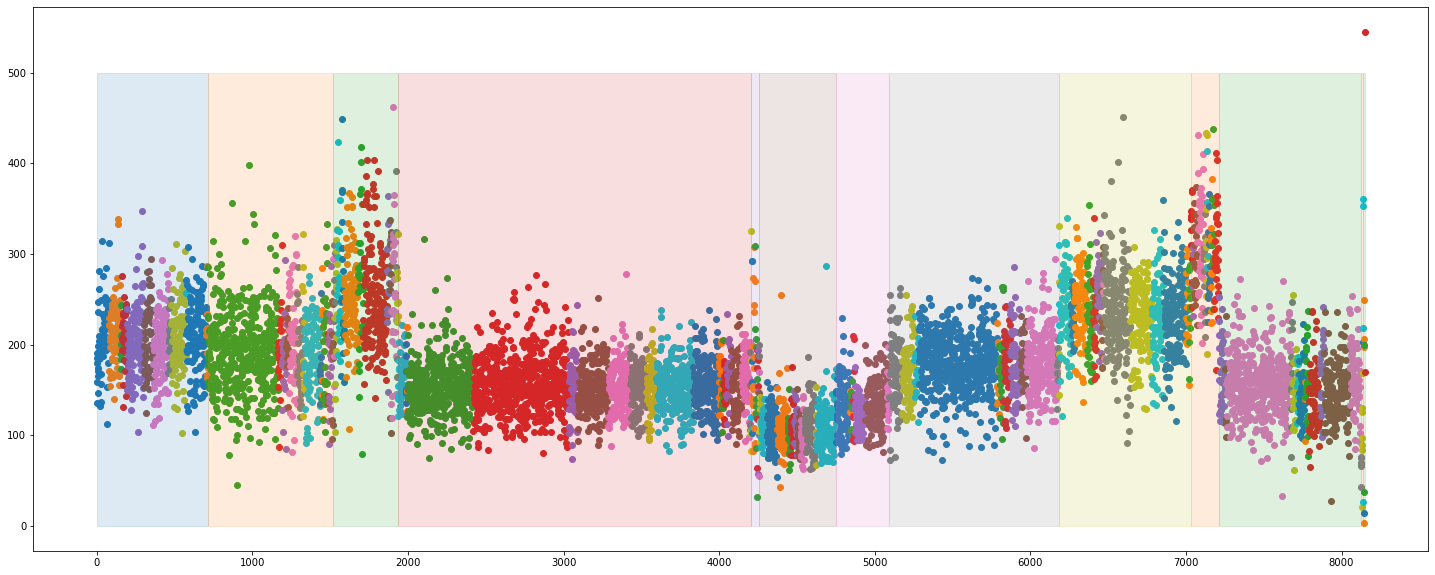

In [175]:
dp_pickle.visualize_DP_run(4, './tst')

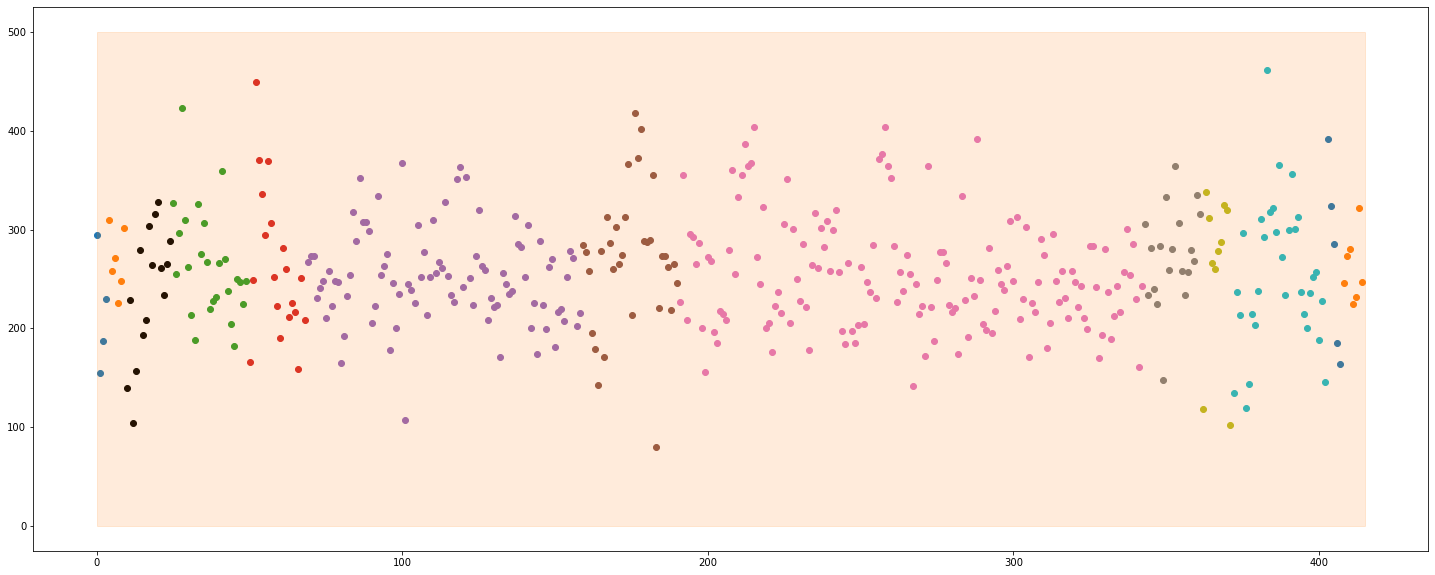

In [208]:
visualize_DP_clust(dp_pickle, 4, 2, 21)

<img src='exome_results/coverage_mcmc_clusters/figures/cov_mcmc_cluster_1_visual.png' />

removing ACDP clusters with fewer than 20 bins

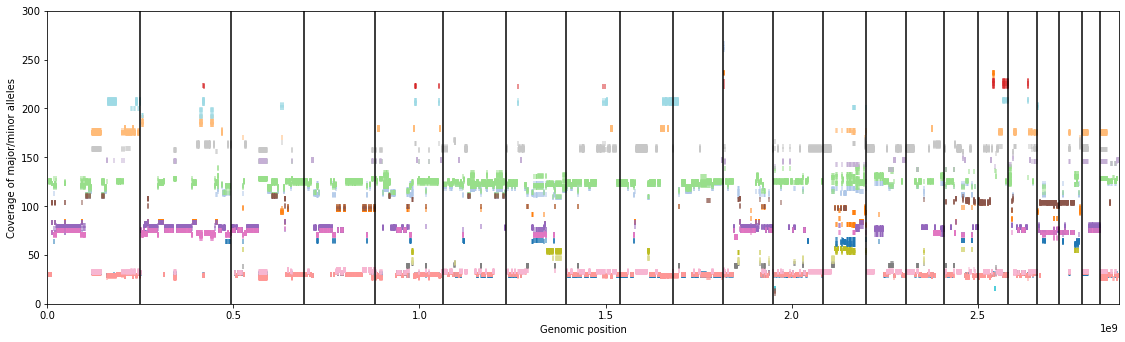

In [68]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        major, minor = x['maj_count'].sum(), x['min_count'].sum()
        if len(x) <= 20:
            continue
        for (_, st, en, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st, en],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [210]:
full_df[s][1]

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID,min_count,maj_count,cov_DP_cluster,cov_DP_mu,cov_DP_sigma,next_g,allele,a_cov_segID,seg_min_count,seg_maj_count,dp_draw
738,1,228412159,228412435,78836,124738,228412159,228412435,277,1.031378,1.536248,0.638989,0.214756,2,35,46.000000,764.236207,4,5.081219,0.000726,228451816,-1,24626,67.860303,954.676207,9
739,1,228451816,228452092,98688,149064,228451816,228452092,277,1.110639,2.096004,0.671480,0.253566,2,35,21.860303,190.440000,4,5.081219,0.000726,228468230,-1,24626,67.860303,954.676207,9
776,1,236700796,236700885,29927,49661,236700796,236700885,90,0.789949,-0.479922,0.500000,0.022820,2,35,19.320000,772.980328,4,5.081219,0.000726,236702178,-1,24632,19.320000,772.980328,9
1021,2,88396113,88396303,42612,67065,337646734,337646924,191,0.846589,0.043592,0.492147,0.010431,2,37,43.240000,263.198053,4,5.081219,0.000726,337674633,-1,24662,43.240000,263.198053,9
1129,2,168114366,168115873,553995,834038,417364987,417366494,1508,0.705876,-1.330663,0.371353,-0.209945,2,37,76.360000,1018.690139,4,5.081219,0.000726,418966642,-1,24678,76.360000,1018.690139,9
2550,6,31238849,31239125,89909,133299,1093780809,1093781085,277,0.875717,0.299340,0.685921,0.270216,2,37,2.760000,62.083262,4,5.081219,0.000726,1093781335,-1,24952,2.760000,62.083262,9
3006,7,22202014,22202159,26450,43221,1255859041,1255859186,146,0.864386,0.200879,0.397260,-0.157173,2,37,17.480000,300.797775,4,5.081219,0.000726,1256821693,-1,25049,17.480000,300.797775,9
3326,8,8233762,8235588,734470,1103531,1401029452,1401031278,1827,0.824167,-0.159338,0.636015,0.211105,2,37,247.048850,1613.837951,4,5.081219,0.000726,1401355598,-1,25121,247.048850,1613.837951,9
3645,9,39118099,39118256,20057,26868,1578277811,1578277968,158,0.647024,-1.988827,0.487342,0.002754,2,37,0.874412,22.080000,4,5.081219,0.000726,1579862363,-1,25180,0.874412,22.080000,9
3866,9,137686927,137686972,21770,34609,1676846639,1676846684,46,1.045485,1.638950,0.760870,0.351363,2,37,22.080000,379.494867,4,5.081219,0.000726,1676938725,-1,25213,22.080000,379.494867,9


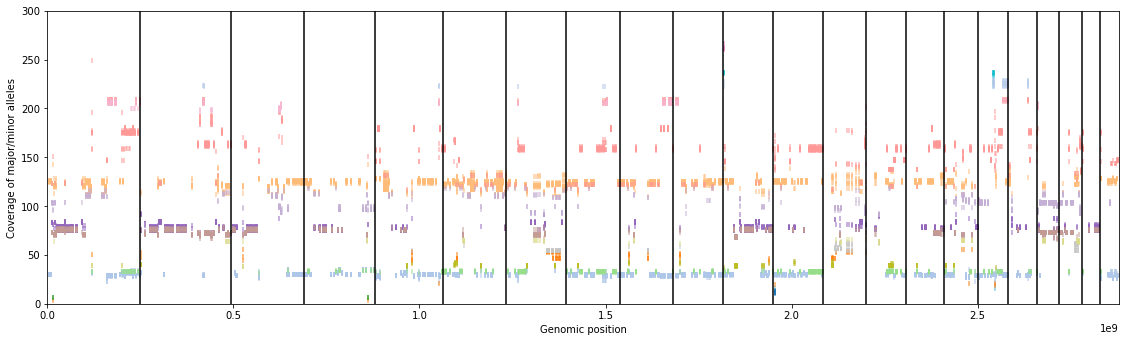

In [229]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "next_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        for (_, st, en, _, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            seg_len = en - st
            seg_len = min(1e6, seg_len)
            plt.plot(
                np.r_[st, st+seg_len],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

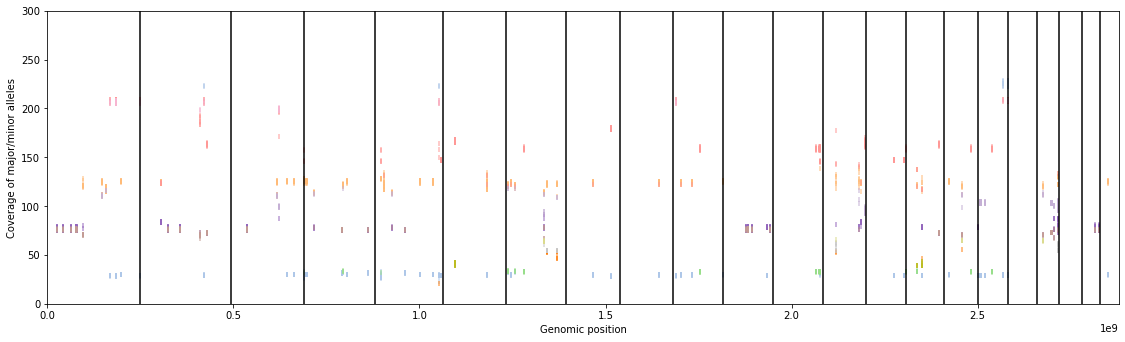

In [225]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        for (_, st, en, _, cov, allele, _, _) in x.itertuples():
            if allele==-1:
                f = minor / (minor + major)
            else:
                f = major / (minor + major)
            plt.plot(
                np.r_[st -20000, en+20000],
                f*np.exp(cov)*np.r_[1, 1],
                color = np.array(colors)[c % len(colors)],
                linewidth = 5,
                solid_capstyle = "butt"
            )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [263]:
def _scatter_apply(x, minor, major):
    f = np.zeros(len(x))
    f[x.allele == -1] = minor / (minor + major)
    f[x.allele == 1] = major / (minor + major)
    locs = x.start_g.values + (x.end_g.values - x.start_g.values)/2
    return locs, f

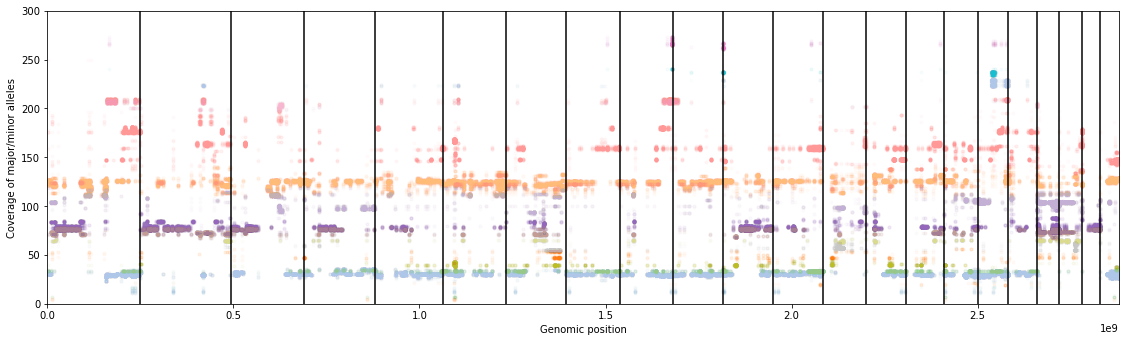

In [276]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

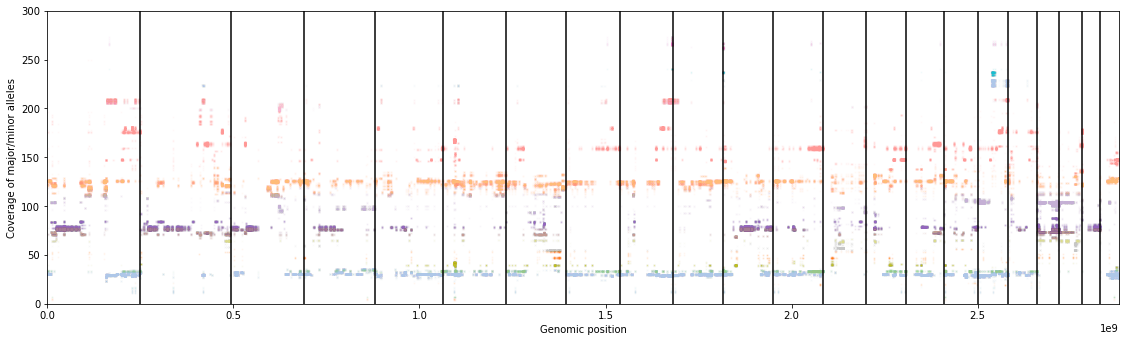

In [278]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);